In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

In [2]:
from matplotlib import rcParams
rcParams.update({
    "font.size": 14})

## Load in FEM Validation Data

In [3]:
burgers = scipy.io.loadmat('matlab/burgers.mat')
X_ = torch.from_numpy(burgers['X']).reshape(-1).float()
T_ = torch.from_numpy(burgers['T']).reshape(-1).float()
u_ = torch.from_numpy(burgers['u']).reshape(-1).float()
X_.requires_grad = True
T_.requires_grad = True
xmin = X_.min()
xmax = X_.max()
N_x = X_.shape[0]

In [4]:
X_.shape, T_.shape, u_.shape

(torch.Size([301]), torch.Size([101]), torch.Size([30401]))

In [5]:
u_ = u_.reshape(X_.shape[0], T_.shape[0])

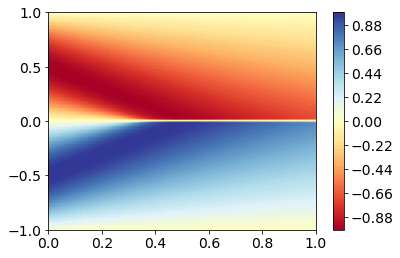

In [6]:
## Evaluate network
x_, t_ = torch.meshgrid(X_, T_)
plt.contourf(t_.detach(), x_.detach(), u_.detach(), levels=100, cmap='RdYlBu')
plt.colorbar()
plt.show()

In [7]:
x_eval = x_.reshape(-1, 1)
t_eval = t_.reshape(-1, 1)

## Defining the function and solution

In [8]:
import math
pi = torch.tensor(math.pi)

In [9]:
nu = 1/(100*pi)
_u_i = lambda x: -torch.sin(pi*x)
_u_b = lambda t: 0*t

In [10]:
n_x = 20 # Number of data points in interior domain
n_i = 20 # Number of initial points
n_b = 20 # Number of boundary (time) points
n_t = 20
xmin = -1
xmax = 1

# Interior of domain
X = torch.linspace(xmin, xmax, n_x+2, requires_grad=True)[1:-1]
T = torch.linspace(0, 1, n_t+1, requires_grad=True)[1:]
x, t = torch.meshgrid((X, T))
x = x.reshape(-1, 1)
t = t.reshape(-1, 1)

# Initial
x_i = torch.linspace(xmin, xmax, n_i,requires_grad=True).reshape(-1, 1)[1:-1]
t_i = torch.zeros(x_i.shape, requires_grad=True)
u_i = _u_i(x_i)

# Boundary
x_b = torch.cat((xmin*torch.ones(n_b, 1, requires_grad=True),
                 xmax*torch.ones(n_b, 1, requires_grad=True)))
t_b = torch.cat((torch.linspace(0, 1, n_b, requires_grad=True),
                torch.linspace(0, 1, n_b, requires_grad=True)), dim=0).reshape(-1, 1)
u_b = _u_b(t_b)

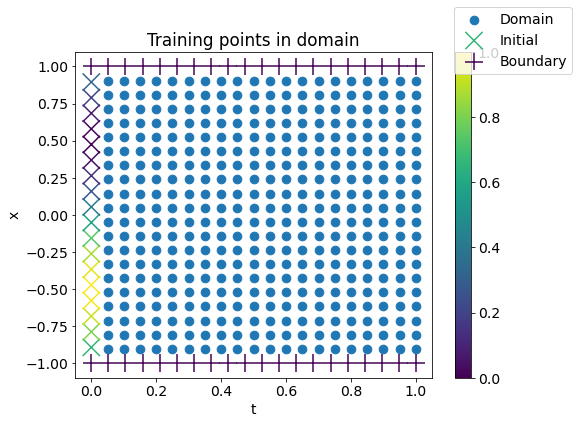

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
d = ax.scatter(t.detach(), x.detach(), marker='.', s=300, label='Domain')
i = ax.scatter(t_i.detach(), x_i.detach(), c=u_i.detach(), marker='x', s=300, label='Initial')
b = ax.scatter(t_b.detach(), x_b.detach(), c=u_b.detach(), marker='+', s=300, label='Boundary')
fig.colorbar(d)
fig.legend()
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Training points in domain')
plt.show()

In [12]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        N_layers=4,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        act_func=nn.Sigmoid()
                ):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                act_func,
                *(nn.Linear(in_features=N_hid,
                    out_features=N_hid,
                    bias=True), act_func)*(N_layers - 1),
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        out = self.layers(x)
        return out
    
    def PDE(self, x, t):
        u_hat = self.forward(x, t)
        u_x_hat = torch.autograd.grad(u_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_xx_hat = torch.autograd.grad(u_x_hat, x, torch.ones(x.shape), create_graph=True)[0]
        u_t_hat = torch.autograd.grad(u_hat, t, torch.ones(t.shape), create_graph=True)[0]
        
        pde = nu*u_xx_hat - u_hat*u_x_hat - u_t_hat.reshape(u_x_hat.shape)
        return pde
    
    def loss_BC(self, x_b, t_b, u_b):
        u_b_hat = self.forward(x_b, t_b)
        loss = self.loss_func(u_b, u_b_hat.reshape(u_b.shape))
        return loss
    
    def loss_IC(self, x_i, t_i, u_i):
        u_i_hat = self.forward(x_i, t_i)
        loss = self.loss_func(u_i, u_i_hat.reshape(u_i.shape))
        return loss

    def loss_PDE(self, x, t):
        pde = self.PDE(x, t)
        loss = self.loss_func(pde, torch.zeros(pde.shape, requires_grad=True))
        return loss
    
    def loss(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        loss = self.loss_PDE(x, t) + self.loss_BC(x_b, t_b, u_b) + self.loss_IC(x_i, t_i, u_i)
        return loss
    
    def step(self, x, t, x_b, t_b, u_b, x_i, t_i, u_i):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return self.loss_PDE(x, t), self.loss_BC(x_b, t_b, u_b), self.loss_IC(x_i, t_i, u_i)

In [13]:
def MSE(net, u_, x, t):
    u = u_.detach().reshape(-1,1)
    u_hat = net(x,t).detach().reshape(-1,1)
    MSE = torch.mean((u - u_hat)**2)
    return MSE

In [14]:
def progress(i, total):
    print("\r", '{:.2f}% '.format((i+1)*100/total), end="")

In [ ]:
epochs = 10000
loss_pde, loss_bc, loss_ic = torch.zeros(epochs), torch.zeros(epochs), torch.zeros(epochs)
loss_data = torch.zeros(epochs)
N_hid = 100
N_layers = 3
net = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers)
for e in range(epochs):
    loss_pde[e], loss_bc[e], loss_ic[e] = net.step(x, t, x_b, t_b, u_b, x_i, t_i, u_i)
    loss_data[e] = MSE(net, u_, x_eval, t_eval)
    progress(e, epochs)
    if (e+1)%500 == 0:
        print('\nEpoch: {:d}. Data loss: {:.2f}'.format(e+1, loss_data[e]))

 5.00% 
Epoch: 500. Data loss: 0.10
 10.00% 
Epoch: 1000. Data loss: 0.09
 15.00% 
Epoch: 1500. Data loss: 0.08
 20.00% 
Epoch: 2000. Data loss: 0.06
 25.00% 22.37% 
Epoch: 2500. Data loss: 0.04
 27.84% 

Save the NN model to disk (for caching)

In [ ]:
#N_hid = 100
#N_layers = 3
model_path = './model/net__N_hid_' + str(N_hid) + '__N_layers_' + str(N_layers)
torch.save(net.state_dict(), model_path)

Load the model in from disk (for evaluation)

In [72]:
model = Net(N_in=2, N_out=1, N_hid=N_hid, N_layers=N_layers)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

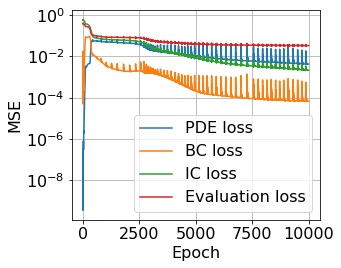

In [73]:
fig, ax = plt.subplots(figsize=(5,4))
ax.semilogy(loss_pde.detach(), label='PDE loss')
ax.semilogy(loss_bc.detach(), label='BC loss')
ax.semilogy(loss_ic.detach(), label='IC loss')
ax.semilogy(loss_data, label='Evaluation loss')
ax.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.grid()
fig.tight_layout()
fig.savefig('./figs/Burger_loss.png', dpi=600)

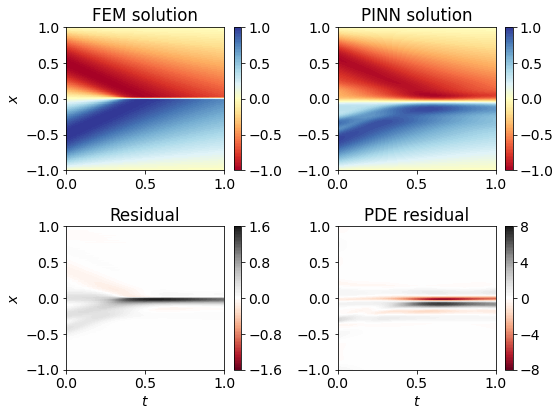

In [94]:
## Evaluate network
fig, axs = plt.subplots(2,2,figsize=(8,6))
axs = axs.flatten()
u_hat = net(x_eval, t_eval).detach().reshape(u_.shape)
pde_hat = net.PDE(x_eval, t_eval).detach().reshape(u_.shape)
vmin = -1 # u_hat.min()
vmax = 1 # u_hat.max()

levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[0].contourf(t_.detach(), x_.detach(), u_.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[0])
cb.set_ticks(c_levels)
axs[0].set_title('FEM solution')
# axs[0].set_xlabel('$t$')
axs[0].set_ylabel('$x$')

m = axs[1].contourf(t_.detach(), x_.detach(), u_hat.detach(), levels=levels, cmap='RdYlBu')
cb = fig.colorbar(m, ax=axs[1])
cb.set_ticks(c_levels)
axs[1].set_title('PINN solution')
# axs[1].set_xlabel('$t$')
# axs[1].set_ylabel('$x$')

vmin = -np.round((u_-u_hat).abs().max(),1)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)

m = axs[2].contourf(t_.detach(), x_.detach(), (u_-u_hat).detach(), levels=levels, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[2])
cb.set_ticks(c_levels)
axs[2].set_title('Residual')
axs[2].set_xlabel('$t$')
axs[2].set_ylabel('$x$')

vmin = -np.round(pde_hat.abs().max(),0)
vmax = -vmin
levels = torch.linspace(vmin, vmax, 100)
c_levels = torch.linspace(vmin, vmax, 5)
m = axs[3].contourf(t_.detach(), x_.detach(), pde_hat.detach(), levels=levels, vmin=vmin, vmax=vmax, cmap='RdGy')
cb = fig.colorbar(m, ax=axs[3])
cb.set_ticks(c_levels)
axs[3].set_title('PDE residual')
axs[3].set_xlabel('$t$')
# axs[3].set_ylabel('$x$')

fig.tight_layout()
fig.savefig('./figs/burgers_2D.png', dpi=600)


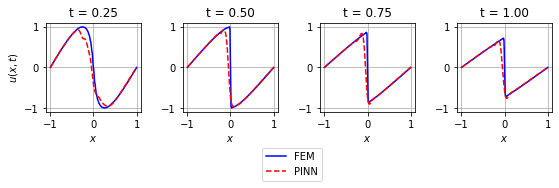

In [53]:
xi, ti = torch.meshgrid(torch.linspace(xmin,xmax,N_x, requires_grad=True), torch.tensor([0.25, 0.5, 0.75, 1]))
#xi, ti = xi.reshape(4, -1), ti.reshape(4, -1)
fig, axs = plt.subplots(1,4,figsize=(8,2.2))
for k, ax in enumerate(axs):
    x = xi[:, k].reshape(-1,1)
    t = ti[:, k].reshape(-1,1)
    u_hat = net(x, t).detach()
    ax.plot(x.detach(), u_[:, (k+1)*25], color='blue', ls='-')
    ax.plot(x.detach(), u_hat, color='red', ls='--')
    ax.set_xlabel('$x$')
    ax.set_title('t = {:.2f}'.format(t[0].item()))
    ax.set_ylim([-1-0.1,1+0.1])
    ax.grid()
axs[0].set_ylabel('$u(x,t)$')
fig.legend(['FEM', 'PINN'], loc="lower center", bbox_to_anchor=(0.53, -0.2))
fig.tight_layout()
fig.savefig('./figs/burger_eval_1D.pdf', bbox_inches='tight')